In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# I decided to do this with a package first to get an idea of what I am looking for since it is hard to develop without direction.
# Loading my dataset
ibm = pd.read_csv("IBMDataset.csv")

# Setting up the model
y = ibm['MonthlyIncome']
X = ibm.select_dtypes(include=[np.number]).drop(['MonthlyIncome', 'EmployeeNumber'], axis=1)
X = X.dropna(axis=1)

# Need to scale my data before I do feature selection:
# I did z-scaling from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Setting up with packages

In [3]:
# I decided to use a package first but my implementation was kind of bloated for forward selection so I dug around and found this package.
# It is from SKlearn and is very effficient.
estimator = LinearRegression()

# Using sequential feature selector from sklearn:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

# Here i setup my feature selector, i messed around with the tolerance a bit, using r2 scoring since that is what my scratch model uses
sfs = SequentialFeatureSelector(
    estimator,
    n_features_to_select="auto",  # Use 'auto' to stop based on tolerance
    tol=0.00001,  # Minimum score improvement to add a feature
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)

# Fitting the selector to my model
sfs.fit(X_scaled, ibm['MonthlyIncome'])

# Gettting the selected features, this is also from the sklearn documentation
selected_features = list(X_scaled.columns[sfs.get_support()])
print("\nSelected Features:")
print(selected_features)


Selected Features:
['DistanceFromHome', 'HourlyRate', 'JobLevel', 'TotalWorkingYears', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [4]:
# Checking summary statistics (thankfully Statsmodel already does this)
# I first quickly get my model from OLS using the features selected from the package above then get summary statistics.
X_selected = sm.add_constant(X_scaled[selected_features])
model = sm.OLS(ibm['MonthlyIncome'], X_selected).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          MonthlyIncome   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2373.
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        21:18:22   Log-Likelihood:                -12773.
No. Observations:                1470   AIC:                         2.556e+04
Df Residuals:                    1463   BIC:                         2.560e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

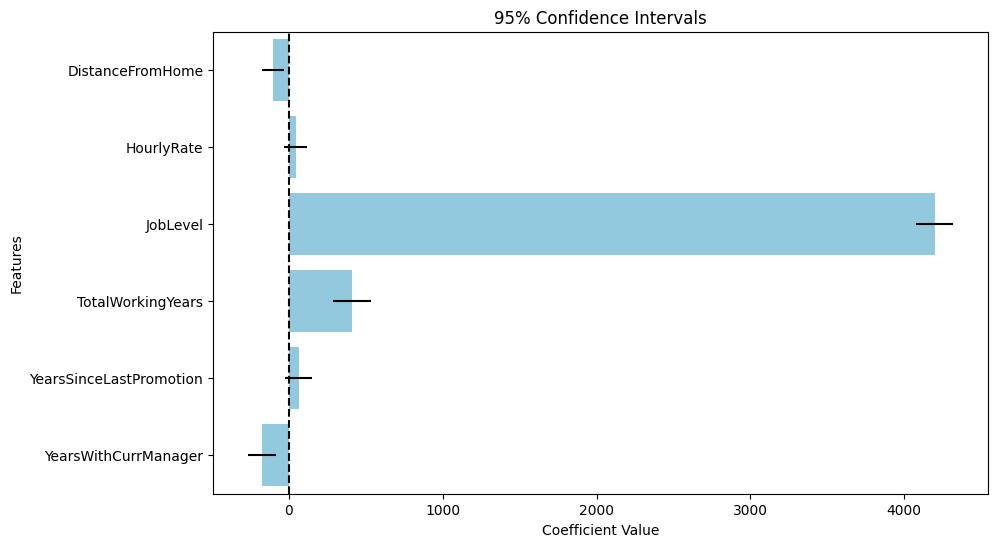

In [5]:
# The purpose of this is to create a plot of confidence intervals, this is just an easy way to visualize the model.
# I drop the intercept coefficient since I don't care about plotting it here
coefs = model.params.drop("const")
conf = model.conf_int().drop("const")
errors = coefs - conf[0]

# Plotting the confidence intervalswith a bit of customization
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs.values, y=coefs.index, orient='h', color='skyblue', xerr=errors.values)
plt.axvline(x=0, color='black', linestyle='--')
plt.title("95% Confidence Intervals")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()
# Used official documentation for the little customization tidbits: https://matplotlib.org/stable/users/explain/quick_start.html

In [6]:
# I also wanted to run a quick check with 
lasso = LassoCV(cv=5, random_state=7) # running lasso with 5 cross validations and seed of 7 (my fav number)
lasso.fit(X_scaled, y) # Re-using my scaled data

# Getting results from lasso
selected_lasso_features = X.columns[lasso.coef_ != 0]
print("Selected features from Lasso:", selected_lasso_features)
print("R^2:", lasso.score(X_scaled, y))

# This is pretty much identical to forward subset so i don't think its valuable to re-do this from scratch.
# Used official documentation for the lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Selected features from Lasso: Index(['DistanceFromHome', 'HourlyRate', 'JobLevel', 'TotalWorkingYears',
       'YearsWithCurrManager'],
      dtype='object')
R^2: 0.9062828031563842


# Setting up from scratch

Most of this code comes from my hw 3 (simple linear regression class) and exam 2 (implemented forward subset selection).

I will point out any new code and mention where it came from and/or anotate it.

### Setting up my classes

In [7]:
# My code for linear reg from hw 3: (I had to add the r_squared feature to work with the code from medium that i had used for exam 2)
class MyLinearReg():
    # Here I am creating a constructor for my class
    def __init__(self, learning_rate, it):
        self.learning_rate = learning_rate # This if for gradient descent
        self.it = it # This is for gradient decent
        
    # This trains the model
    def fit(self, X, Y):
        # Initializing X and Y
        X = np.array(X)
        Y = np.array(Y)
        
        # n is the number of features (2)
        self.m, self.n = X.shape 
        
        # Initializing my weight
        self.B = np.zeros(self.n) # Modified this to allow for more B
        self.b_0 = 0
        self.X = X
        self.Y = Y
        
        # This is the gradient decent
        for i in range(self.it):
            self.update_weights()
        return self
    
    # This is the implementation of gradient decent formula
    def update_weights(self):
        Y_pred = self.predict(self.X)
        dB = -(2 * (self.X.T).dot(self.Y - Y_pred)) / self.m
        db_0 = -2 * np.sum(self.Y - Y_pred) / self.m
        
        # Here the weight is adjusted according to the learning rate.
        self.B = self.B - self.learning_rate * dB
        self.b_0 = self.b_0 - self.learning_rate * db_0
        
        return self
    
    def predict(self, X):
        return X.dot(self.B) + self.b_0 
    
    def describe(self):
        print("The values of B is:", self.B)
        print("The value of B_0 is: ", self.b_0)
        
    # I had to add this for the forward stepwise, i just used the r^2 formula we have covered in book/class
    # also used this for formula: https://en.wikipedia.org/wiki/Coefficient_of_determination
    def r_squared(self):
        y_pred = self.predict(self.X)
        ss_res = np.sum((self.Y - y_pred) ** 2)
        ss_tot = np.sum((self.Y - np.mean(self.Y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return r2

In [8]:
# Unlike exam 2, I don't need to drop all non numeric since my data has already been scaled (removed categorical)
print(X_scaled.dtypes) # everything is already numerical.

Age                         float64
DailyRate                   float64
DistanceFromHome            float64
Education                   float64
EmployeeCount               float64
EnvironmentSatisfaction     float64
HourlyRate                  float64
JobInvolvement              float64
JobLevel                    float64
JobSatisfaction             float64
MonthlyRate                 float64
NumCompaniesWorked          float64
PercentSalaryHike           float64
PerformanceRating           float64
RelationshipSatisfaction    float64
StandardHours               float64
StockOptionLevel            float64
TotalWorkingYears           float64
TrainingTimesLastYear       float64
WorkLifeBalance             float64
YearsAtCompany              float64
YearsInCurrentRole          float64
YearsSinceLastPromotion     float64
YearsWithCurrManager        float64
dtype: object


In [9]:
# This is my forward subset selection from exam 2 with some minor modifications
ar2 = {}
candidates = []
last_max = -1

# I added this since it was selecting too many features and I wanted to make the model more strict:
MIN_IMPROVEMENT = 0.0001

# The algorithm just runs until there is no more improvement
while True:
    ar2.clear()  # I reset this to ensure it is not bloated

    # Make sure that each feature is tested
    for feature in X_scaled.drop(columns=candidates).columns:
        current_features = candidates + [feature]
        
        # Train the model with the custom implementation from hw3
        # I did guess and check for the parameters, higher learning rates gave me nan and lower learning rates were too inaccurate
        model = MyLinearReg(it=10000, learning_rate=0.001)
        model.fit(X_scaled[current_features].values, ibm['MonthlyIncome'].values)
        
        # Calculate adjusted R2 val for checking improvement
        ar2[feature] = model.r_squared()

    # Find the best new feature from the model
    max_ar2 = max(ar2.values())
    max_ar2_key = max(ar2, key=ar2.get)

    # Checking for improvement in the model
    if max_ar2 > last_max + MIN_IMPROVEMENT: # small workaround to ensure that the R2 value increases more than like 0.0000000001
        candidates.append(max_ar2_key)
        last_max = max_ar2

        print(f"Step: {len(candidates)}")
        print(f"Selected features: {candidates}")
        print(f"Adjusted R^2 val: {max_ar2:.4f}")
        print("===============")
    else:
        # If the code ends here the is no longer improving at this point so stop the execution
        model.describe()
        break

print("\n\nEliminated variables:")
print(set(X_scaled.columns).difference(candidates))

Step: 1
Selected features: ['JobLevel']
Adjusted R^2 val: 0.9031
Step: 2
Selected features: ['JobLevel', 'TotalWorkingYears']
Adjusted R^2 val: 0.9053
Step: 3
Selected features: ['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager']
Adjusted R^2 val: 0.9061
Step: 4
Selected features: ['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager', 'DistanceFromHome']
Adjusted R^2 val: 0.9066
Step: 5
Selected features: ['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager', 'DistanceFromHome', 'Age']
Adjusted R^2 val: 0.9068
Step: 6
Selected features: ['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager', 'DistanceFromHome', 'Age', 'YearsSinceLastPromotion']
Adjusted R^2 val: 0.9069
The values of B is: [4161.70848497  545.41673453 -166.9978789  -102.20219375 -122.59648508
   70.90797254  -51.50518724]
The value of B_0 is:  6502.931279379231


Eliminated variables:
{'EmployeeCount', 'MonthlyRate', 'NumCompaniesWorked', 'StockOptionLevel', 'WorkLifeBalance', 'DailyRate', 'EnvironmentSati

In [10]:
# Fitting model with everything from my forward subset selection:
X = ibm[['JobLevel', 'TotalWorkingYears', 'YearsWithCurrManager', 'DistanceFromHome', 'Age', 'YearsSinceLastPromotion']]
Y = ibm['MonthlyIncome']

# Tweaked around the parameters and this gave me the best R^2 value.
model = MyLinearReg(learning_rate=0.0001, it=100000)

model.fit(X, Y)

# Getting the summary from my class
model.describe()
print(f'R-squared val {model.r_squared():.4f}')

The values of B is: [3722.28498768   82.75753877  -64.62488884  -16.74099522  -30.57084182
   20.19466473]
The value of B_0 is:  -579.1237845893536
R-squared val 0.9060


### Takeaways:
My forward subset selection performed really well, almost identical to the package execution. My final selected features with their corresponding coefficients are shown below:

1. JobLevel:                 3722.28498768
2. TotalWorkingYears:        82.75753877
3. YearsWithCurrManager:     -64.62488884
4. DistanceFromHome:         -16.74099522
5. Age:                      -30.57084182
6. YearsSinceLastPromotion:  20.19466473

Which is almost identical to the model done with packages with a few small differences.

And my r-squared value was: 0.906, which is only a tad behind the package model at 0.907.

Overall, I am very happy with my model and think that it performs surprisingly well.

# Model Evaluation

In [11]:
# Since the instructions said that it was okay to use packages for evaluation i decided to use sklearn metrics.
# This includes a ton of useful metrics to evaluate the model.
y_pred = model.predict(X)

# Here i am calculating my metrics
# I decided to go with these three since they are standard and rmse is more interpretable than mse and was suggested in the instructions. 
# Same with mean absolute error
r2 = r2_score(Y, y_pred)
rmse = np.sqrt(mean_squared_error(Y, y_pred))
mae = mean_absolute_error(Y, y_pred)

print(f"R-squared Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Source: https://scikit-learn.org/stable/api/sklearn.metrics.html
# Source: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

R-squared Score: 0.9060
RMSE: 1443.0665
MAE: 1093.3619


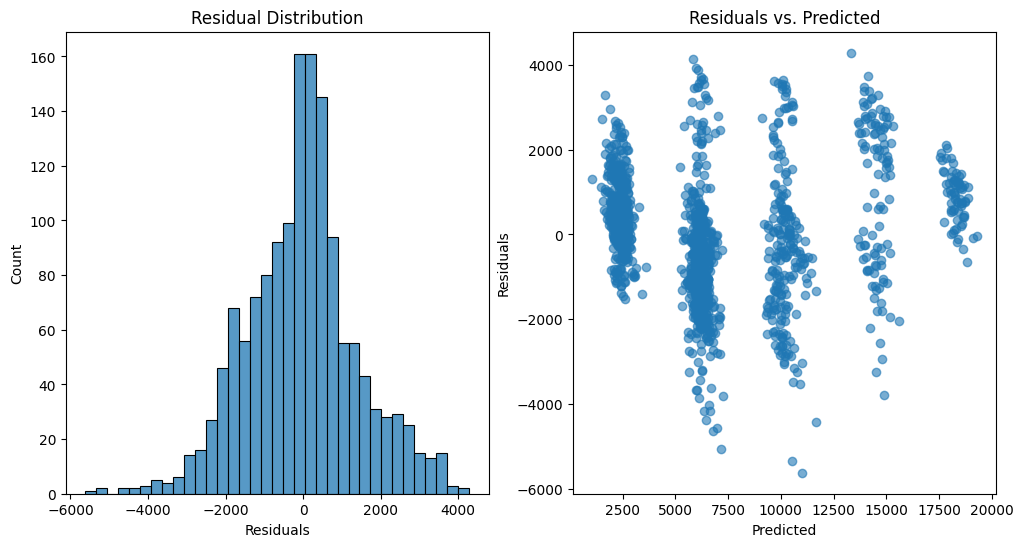

In [12]:
# I also decided to do a residual plot to check out if anything looked off
residuals = Y - y_pred

plt.figure(figsize=(12, 6))

# Plot 1: residual distrubution
plt.subplot(1, 2, 1)
sns.histplot(residuals)
plt.title("Residual Distribution")
plt.xlabel("Residuals")

# Plot 2: residuals vs predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6) # reduced alpha to see better
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.show()

# I took inspiration from this but obviously didnt use OLS: https://www.statology.org/residual-plot-python/

# Conclusion
Please look at the actual report for my analysis of all of these things and a deeper breakdown of my model.